# Estimating probabilities to predict heart disease

Suppose we know someone's age, rest blood pressure, and max heart rate, and want to predict whether they have heart disease.  To be more concrete, suppose the person's age is between 40 and 45, rest blood pressure is between 120 and 130, and max heart rate is between 110 and 120.  Should we predict heart disease or not?

In class we learned that, using the MAP method, we should compare these two conditional probabilities:

- P(output = 0 | age in [40,45), blood pressure in [120, 130), and max heart rate in [110,120))
- P(output = 1 | age in [40,45), blood pressure in [120, 130), and max heart rate in [110,120))

(The notation age in [120, 130) is shorthand for age >= 120 and age < 130.)

We know how to estimate conditional probabilities from data, so why don't we just estimate these probabilities to find the answer?

In fact, why do we need any machine learning algorithms?

In this assignment we'll understand the problem with trying to use MAP directly, and look at ideas on how to solve it.

In [3]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

In [4]:
# graphics
sns.set()
sns.set_context('talk')

# change default plot size
rcParams['figure.figsize'] = 7,5

In [5]:
def hist2d(x, y, num_bins, ranges, bar_fraction=0.75):
    """ Plot a 3d histogram.
    This code based on: https://matplotlib.org/stable/gallery/mplot3d/hist3d.html 
    """

    # plot parameters
    bin_widths  = [ (range[1] - range[0])/n for range, n in zip(ranges, num_bins) ]
    bar_widths  = [ bar_fraction * w for w in bin_widths ]
    bar_offsets = [ (bin_width - bar_width)/2 for bin_width, bar_width in zip(bin_widths, bar_widths) ]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    hist, xedges, yedges = np.histogram2d(x, y, bins=num_bins, range=ranges)

    # bar anchor positions
    xpos, ypos = np.meshgrid(xedges[:-1] + bar_offsets[0], yedges[:-1] + bar_offsets[1], indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # bar dimensions
    dx = bar_widths[0]
    dy = bar_widths[1]
    dz = hist.ravel()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

### Read the data

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/grbruns/cst383/master/heart.csv')
df['output'] = df['output'] - 1

# all rows are used, but not all variables
np.random.seed(0)
vars = ['age', 'restbp', 'maxhr', 'output']
df = df[vars]

Basic information about the data frame.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     270 non-null    int64
 1   restbp  270 non-null    int64
 2   maxhr   270 non-null    int64
 3   output  270 non-null    int64
dtypes: int64(4)
memory usage: 8.6 KB


The first five rows of the data set.

In [13]:
df.head()

,age,restbp,maxhr,output
0,70,130,109,1
1,67,115,160,0
2,57,124,141,1
3,64,128,105,0
4,74,120,121,0


Basic statistics about the numeric variables in the data set.

In [14]:
df.describe()

,age,restbp,maxhr,output
count,270.000000,270.000000,270.000000,270.000000
mean,54.433333,131.344444,149.677778,0.444444
std,9.109067,17.861608,23.165717,0.497827
min,29.000000,94.000000,71.000000,0.000000
25%,48.000000,120.000000,133.000000,0.000000
50%,55.000000,130.000000,153.500000,0.000000
75%,61.000000,140.000000,166.000000,1.000000
max,77.000000,200.000000,202.000000,1.000000


### Part 1: Predicting heart disease from maximum heart rate

Suppose all we know is that someone's maximum heart is in the range 100-120.  Using our data, should we predict heart disease or not?

Using the MAP method, we should compute these probabilities:

- P(output = 0 | maxhr in [110, 120))
- P(output = 1 | maxhr in [110, 120))

and then predict output = 0 or output = 1 depending on which probability value is higher.

#@ 1

Let's look at the distribution of maximum heart rate values using a histogram.

Plot a histogram of variable maxhr.  Use bin edges 60, 70, 80, ..., 210.

To control the values displayed on the x axis, look into plt.xticks().

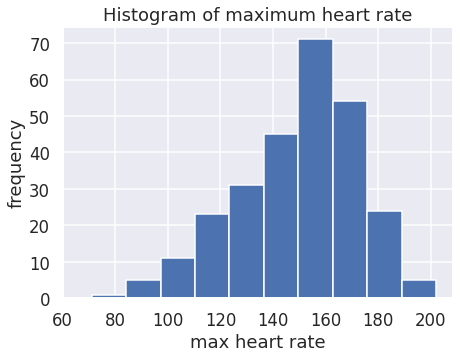

In [33]:
plt.hist(df['maxhr'])
plt.xticks(np.arange(60,210,step=20))
plt.title('Histogram of maximum heart rate')
plt.xlabel('max heart rate')
plt.ylabel('frequency');

#@ 2

Let's look at the distribution of maxhr again, but this time using a kernel density plot.  (We often call them just "density plots".)

Use the pandas method for plotting the kernel density of a series.

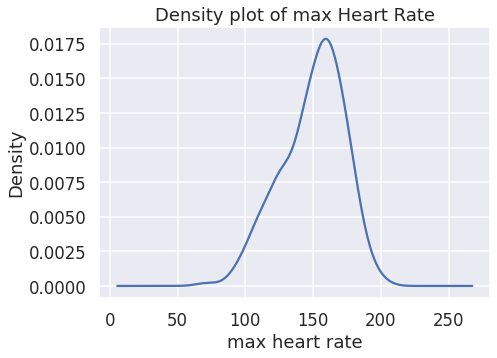

In [41]:
df['maxhr'].plot.kde()
plt.title('Density plot of max Heart Rate')
plt.xlabel('max heart rate');

#@ 3

Using the data, estimate P(output = 0 | (maxhr >= 110, maxhr < 120)).  Save the result as variable p0.

In [25]:
pr=df[(df['maxhr']>=110) & (df['maxhr']<120)]
p0=(pr['output']==0).mean()

In [26]:
print('P(output = 0 | maxhr >= 110, maxhr < 120) = {:.3f}'.format(p0))

P(output = 0 | maxhr >= 110, maxhr < 120) = 0.286


#@ 4

Using only p0, estimate P(output = 1 | (maxhr >= 110, maxhr < 120)).  Save the result as variable p1.

In [36]:
pl=df[(df['maxhr']>=110) & (df['maxhr']<120)]
p1=(pr['output']==1).mean()

In [37]:
print('P(output = 1 | maxhr >= 110, maxhr < 120) = {:.3f}'.format(p1))

P(output = 1 | maxhr >= 110, maxhr < 120) = 0.714


p1 is greater than p0, so using MAP we should predict output = 1.

#@ 5

Is it correct to predict output = 1?  To see, plot the density of max heart rate for the rows of the data set in which output = 0, and plot the density of max heart rate for the rows of the data set in which output = 1.

Include both of the density plots within one plot.  

Use Seaborn's kdeplot().  Take note of the parameters 'hue' and 'common_norm' of kdeplot().

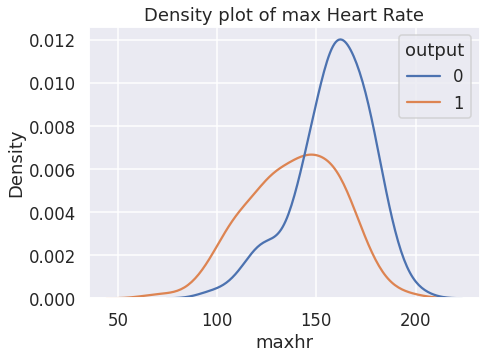

In [127]:
data= df.pivot(columns='output', values = 'maxhr')
sns.kdeplot(data = data, common_norm=True, ).set_xlabel('maxhr')
plt.title('Density plot of max Heart Rate');

From the plot, does it make sense that, if max heart rate is between 110 and 120, then we should predict heart disease?

### Part 2: Predicting heart disease from max heart rate and age

Suppose we know that max heart rate is between 110 and 120, and that age is between 40 and 45.  Can't we do what we did with max heart rate and make a prediction by comparing these two probabilities?

- P(output = 0 | maxhr in [110, 120) and age in [40,45))
- P(output = 1 | maxhr in [110, 120) and age in [40,45))

#@ 6

Compute the dataframe that contains the rows in dataframe df for which maxhr in [110,120) and age in [40,45).  Assign the result to variable df_ma.

In [82]:
df_ma = df[(((df['maxhr'] >= 110) & (df['maxhr'] < 120)) & ((df['age'] >= 40) & (df['age'] < 45)))]


#@ 7

Using df_ma, estimate P(output = 0 | maxhr in [110, 120) and age in [40, 45)) from the data.  Store the result to variable p0.

In [83]:
p0=(df_ma['output']==0).mean()

In [84]:
print('P(output = 0 |  maxhr in [110, 120) and age in [40, 45)) = {:.3f}'.format(p0))

P(output = 0 |  maxhr in [110, 120) and age in [40, 45)) = 0.000


#@ 8

This looks strange.  How many rows in df_ma?  Print the number of rows in df_ma.

In [85]:
df_ma=df.shape[0]

In our data set, there is only one person with maxhr between 110 and 120, and age between 40 and 45.

It makes sense that, for certain ranges of maxhr and age, there won't be much data.

Let's look at the joint distribution of maxhr and age, by using a 3D histogram.

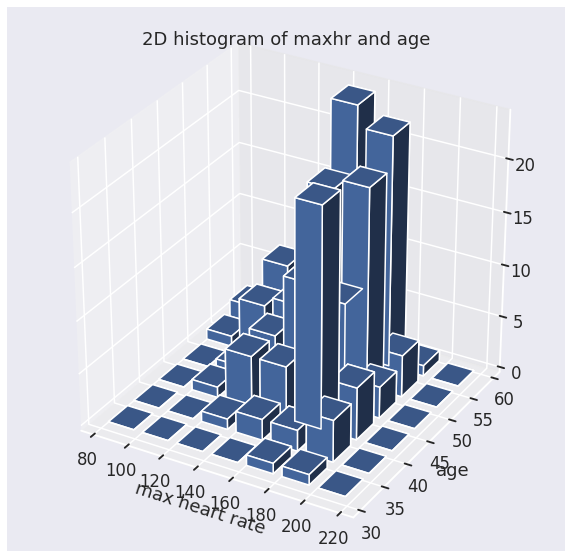

In [55]:
hist2d(df['maxhr'].values, df['age'].values, num_bins=[7, 6], ranges=[[80, 220], [30, 60]])
plt.title('2D histogram of maxhr and age')
plt.xlabel('max heart rate')
plt.ylabel('age');

Remember: in a histogram, the height of a bar shows the number of items in the bin.
In this histogram, many of the bins are empty, or almost empty.  In the example we just looked at, the bin contained only one item.

This problem gets much worse as the number of variables increases.  Let's look at this a little.

First, we "bin" the data for maxhr, restbp, and age.  For example, with maxhr we split the range of values into 10 ranges of the same size, and then transform each value maxhr value to its "range number".  A small maxhr value will become 0.

In [56]:
num_bins = 10
maxhr_binned  = pd.cut(df['maxhr'],  num_bins, labels=False)
restbp_binned = pd.cut(df['restbp'], num_bins, labels=False)
age_binned    = pd.cut(df['age'],    num_bins, labels=False)

Look at some of the binned maxhr values.

In [57]:
print(maxhr_binned.value_counts().sort_index())

0     1
1     5
2    11
3    23
4    31
5    45
6    71
7    54
8    24
9     5
Name: maxhr, dtype: int64


There are 10 bins, and every bin has a count of at least 1.
In other words, the fraction of bins that are non-empty is 1.0

If a bin was empty, value_counts() would not show the bin at all.

#@ 9

Compute the fraction bins of restbp_binned that have at least 1 value, and assign the result to variable nonempty_frac.  The result should be between 0 and 1 (inclusive).

In [95]:
nonempty_frac = ((restbp_binned.value_counts())>=1).mean()

In [96]:
print(nonempty_frac)

1.0


If we have two variables, there are a lot more bins, but the number of rows in the data set doesn't change, so bins will have smaller counts.

#@ 10

If we look at the combination of maxhr_binned and age_binned values in the data set, what fraction of bins are non-empty?

Compute the answer and assign the result to variable nonempty_frac.

Hint: first create a dataframe containing maxhr_binned and age_binned as columns.  Then use value_counts() directly on the data frame.  You will need to figure out the maximum number of bins.

In [159]:
df1 = pd.DataFrame({'maxhr':
maxhr_binned, 'age': age_binned});
nonempty_frac=(len(df1.value_counts())/100)

In [160]:
print(nonempty_frac)

0.59


#@ 11

Repeat the previous problem, but this time use variables maxhr, age, and restbp.  Compute the fraction of bins that are non-empty.

In [162]:
df1 = pd.DataFrame({'maxhr':
maxhr_binned, 'age': age_binned});
nonempty_frac=(len(df1.value_counts())/1000)

In [163]:
print(nonempty_frac)

0.059


If we had 8 variables, we would have $10^{8}$ bins.  That is 100 million bins.  If an 8-variable data set had 1 million rows then at least 99% of the bins would be empty.

This is why, when we have more than a couple of variables, we can't get good estimates of the conditional probabilities we need from the data.  

### Part 3: Ideas for solving the problem

The problem is that the "shape" of data in a high-dimensional space can be very complex.  Unless we have a gigantic amount of data, we can only get a sketchy picture of what the multi-variate distribution is like.

So, what to do about it?

One solution is to make simplifying assumptions about the distribution.  Actually, it's *distributions*, because we want to know the distribution of the variables when there is no heart disease, and when there is heart disease.

For example, we could assume that each variable has a normal distribution.

#@ 12

Create a normal distribution that approximates the distribution of maxhr.
Do this by creating a norm() stats object, using the mean and standard 
deviation of maxhr.  Assign the result to variable maxhr.

In [130]:
mean_maxhr = df['maxhr'].mean()
std_maxhr = df['maxhr'].std()
maxhr = stats.norm(loc=mean_maxhr, scale=std_maxhr)

In [131]:
print('The mean of variable maxhr is {:.1f}'.format(maxhr.mean()))

The mean of variable maxhr is 149.7


#@ 13

Plot the pdf of the normal approximation of maxhr that you have just created.  

Hint: you may want to use np.linspace() and the pdf() method of maxhr().

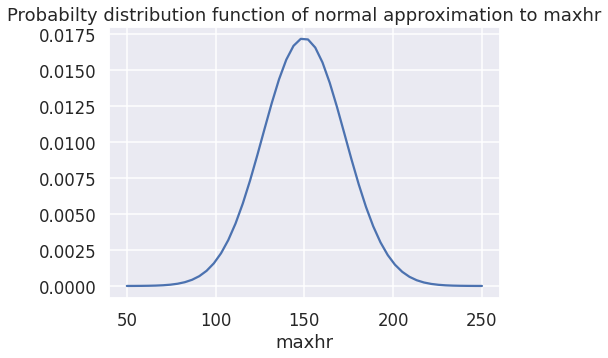

In [133]:
x= np.linspace(50, 250, num=50)
plt.plot(x,maxhr.pdf(x))
plt.title('Probabilty distribution function of normal approximation to maxhr')
plt.xlabel('maxhr');

Why is this a useful thing to do?  Because the normal approximation is robust; it won't look very different if the our data set changes a little.  On the other hand, the shape of a density plot can change if a data set changes a little.

#@ 14

Now create two normal distributions.  The first will approximate the distribution of maxhr when output = 0, and the second will approximate the distribution of maxhr when output = 1.

Create two norm() objects, and assign them to variables maxhr0 and maxhr1.

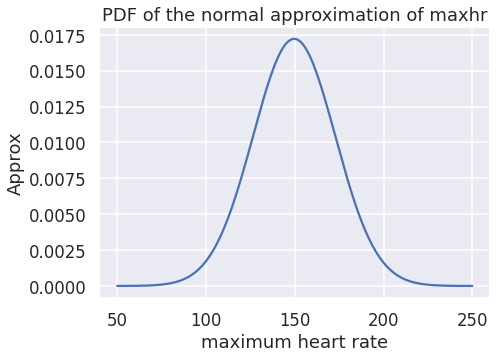

In [166]:
x= np.linspace (50,250,200)
y = maxhr.pdf(x)
plt.plot(x,y);
plt.title ('PDF of the normal approximation of maxhr');
plt.xlabel ('maximum heart rate')
plt.ylabel ('Approx');


#@ 15

Plot the two normal distributions in one plot.  Use plt.plot()

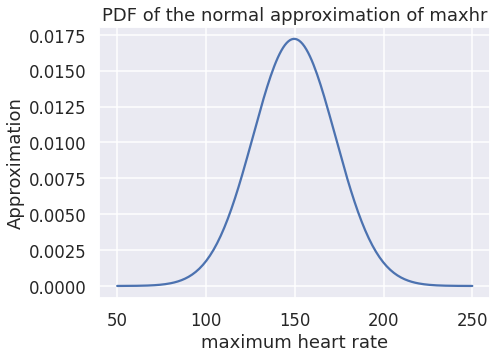

In [164]:
x= np.linspace (50,250,200)
y = maxhr.pdf(x)
plt.plot(x,y);
plt.title ('PDF of the normal approximation of maxhr');
plt.xlabel ('maximum heart rate')
plt.ylabel ('Approximation');
#I think I will not predict heart disease if maxhr is 130

Look at the plot.  If maxhr is 130, would you predict heart disease or not?

To make things even simpler, we can make another assumption: that the standard deviation is the same for the case of heart disease or no heart disease.

This calculation of the variance we will use for both heart disease and no heart disease is very similar to just getting the average of the two variances.

In [140]:
df0 = df[df['output'] == 0]
df1 = df[df['output'] == 1]
maxhr_var = (((df0['maxhr'] - df0['maxhr'].mean())**2).sum() + ((df1['maxhr'] - df1['maxhr'].mean())**2).sum())/df.shape[0]
print('shared variance = {:.1f}'.format(maxhr_var))

shared variance = 441.0


#@ 16

Create and plot normal distributions for maxhr again, but this time use the shared variance value we just computed.


In [167]:
maxhrO=stats.norm(df['maxhr'][df['output']== 0].mean(), np.sqrt(maxhr_var));
maxhr1 = stats.norm( df['maxhr']
[df['output'] == 1].mean(),np.sqrt(maxhr_var));


Think about how we might use this plot to make a prediction of heart disease if we only knew maximum heart rate.

The optimal choice is to pick the max heart rate value where the plots cross, at about 150.  So, if the max heart rate is below 150, predict heart disease, else no heart disease. 